## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

/home/k64835/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/k64835/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Dataset prep: B10 with Date Encodings as Additional Channels

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10 + 2, 64, 64)

2 extra channels for temporal encoding of sin(date_diff) and cos(date_diff)

In [4]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10_channel', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10_channel', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1228, 7, 12, 64, 64]), torch.Size([48, 7, 12, 64, 64]))

Dictionary for subpatch-to-patch mapping of reconstructed images

In [5]:
old_images_train = {fn: img for fn, img in zip(field_numbers_train, images_visualisation_train)}
old_images_eval = {fn: img for fn, img in zip(field_numbers_eval, images_visualisation_eval)}

In [6]:
acq_dict_train = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_train)}
acq_dict_eval = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_eval)}

### Create Sub-Patches

In [8]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([33128, 7, 12, 4, 4]), torch.Size([1197, 7, 12, 4, 4]))

Get field numbers and co-ordinates as string

In [9]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167136.0_1167138.0_24_24'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [10]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

## Modeling: Conv3D Autoencoder with Temporal Encodings

### Architecture

Input Data: ( N x C x D x H x W )

In [11]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, out_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, out_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

### Training

In [29]:
device = 'cuda'
epochs = 50
lr = 0.001
momentum = 0.8
latent_dim = 32
in_channels = 12
out_channels = 10
time_steps = 7
optimizer = 'Adam'
patch_size = config.subpatch_size

model = Conv3DAutoencoder(in_channels, out_channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(12, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [30]:
trained_model, train_losses, test_losses = train_model_ae_te(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Time taken per epoch: 7.0883 seconds
Epoch 1/50, Train Loss: 0.004022, Test Loss: 0.000817
Time taken per epoch: 6.9971 seconds
Epoch 2/50, Train Loss: 0.000558, Test Loss: 0.000320
Time taken per epoch: 7.0212 seconds
Epoch 3/50, Train Loss: 0.000277, Test Loss: 0.000243
Time taken per epoch: 6.9097 seconds
Epoch 4/50, Train Loss: 0.000224, Test Loss: 0.000214
Time taken per epoch: 6.9480 seconds
Epoch 5/50, Train Loss: 0.000202, Test Loss: 0.000186
Time taken per epoch: 6.9107 seconds
Epoch 6/50, Train Loss: 0.000185, Test Loss: 0.000224
Time taken per epoch: 6.9050 seconds
Epoch 7/50, Train Loss: 0.000178, Test Loss: 0.000161
Time taken per epoch: 6.9297 seconds
Epoch 8/50, Train Loss: 0.000165, Test Loss: 0.000161
Time taken per epoch: 7.1617 seconds
Epoch 9/50, Train Loss: 0.000157, Test Loss: 0.000223
Time taken per epoch: 7.0139 seconds
Epoch 10/50, Train Loss: 0.000148, Test Loss: 0.000182
Time taken per epoch: 6.9592 seconds
Epoch 11/50, Train Loss: 0.000137, Test Loss: 0.0001

### Evaluation

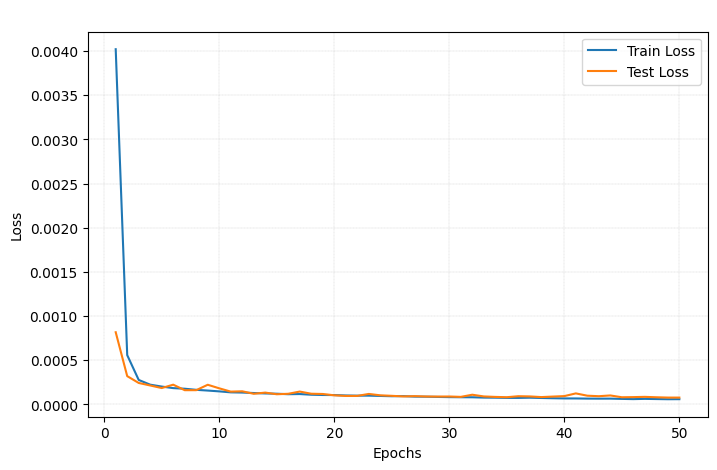

In [31]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training the model

Load Saved Model to skip Training

In [32]:
# with open(config.kmeans_ae_3D_TE_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [33]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_3d_TE_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [34]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=False, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=False, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=False, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [35]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=29)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [36]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 65.57
Precision: 65.91
Recall: 82.86
F1-score: 73.42
F2-score: 78.8


Save Models

In [37]:
# with open(config.ae_3d_TE_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [38]:
# with open(config.kmeans_ae_3D_TE_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

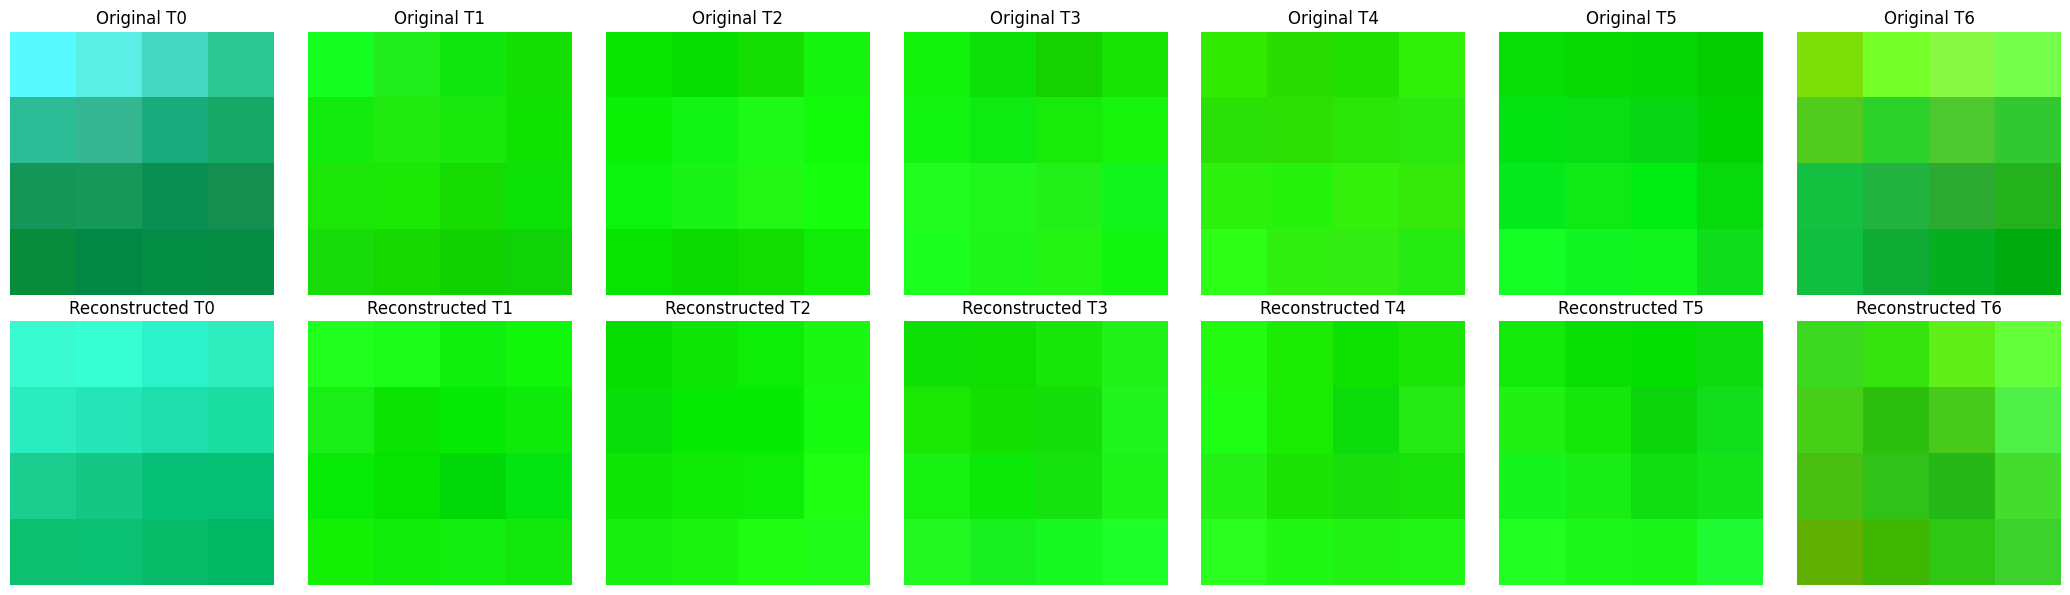

In [41]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_train, 1, device)

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

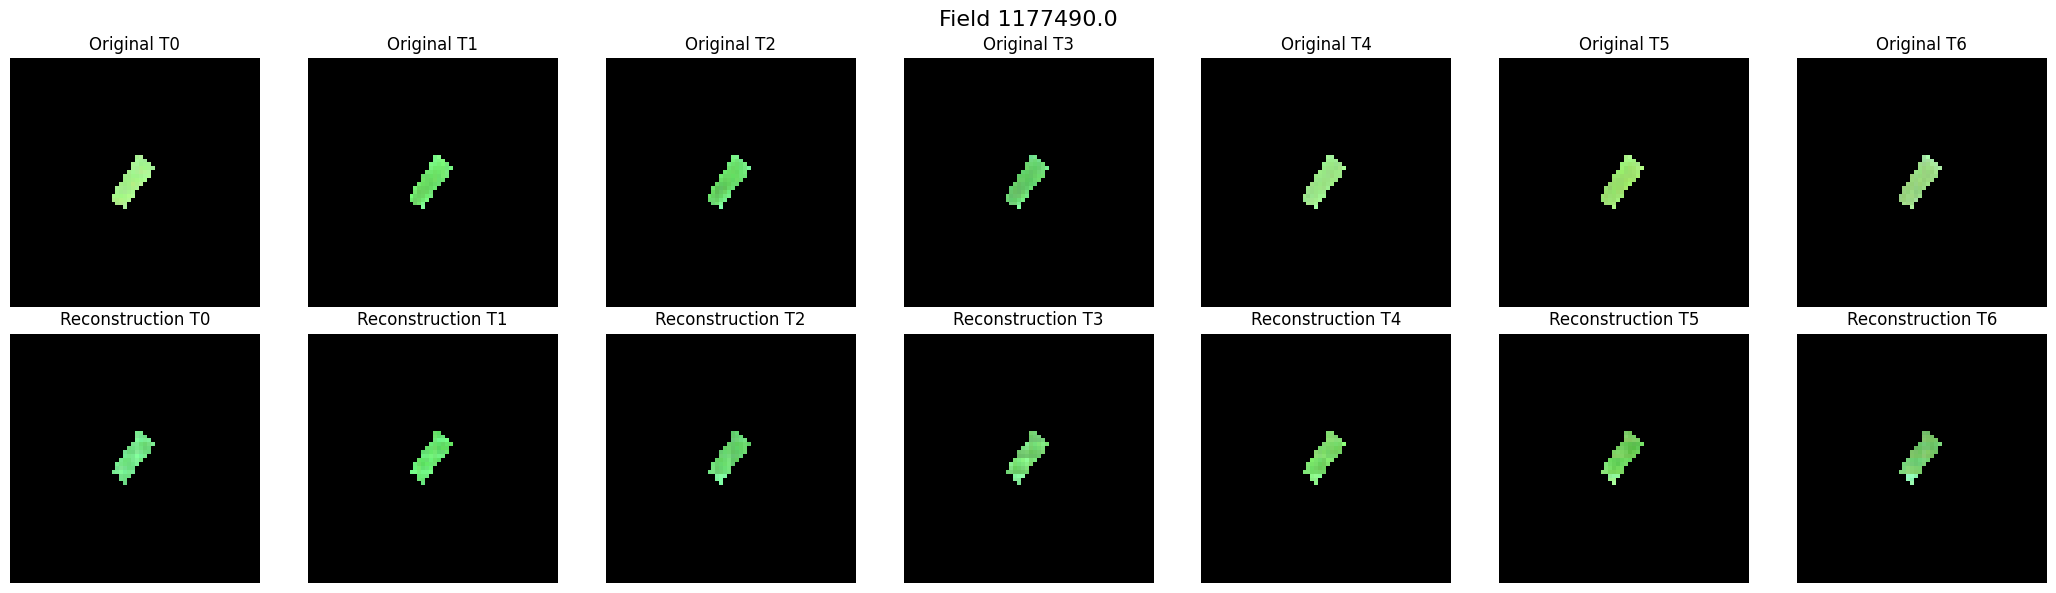

In [69]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device)

## Dataset prep: B10 with Pixel-level Date Encodings addition

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, date_emb_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10_add', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, date_emb_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10_add', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1228, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

In [6]:
date_emb_train[0][0]   # [sin, cos]

[0.6174430228904924, 0.013988542959794681]

Dictionary for subpatch-to-patch mapping of reconstructed images

In [7]:
old_images_train = {fn: img for fn, img in zip(field_numbers_train, images_visualisation_train)}
old_images_eval = {fn: img for fn, img in zip(field_numbers_eval, images_visualisation_eval)}

In [8]:
acq_dict_train = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_train)}
acq_dict_eval = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_eval)}

### Create Sub-Patches

In [9]:
train_subpatches, train_subpatch_coords, train_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_train, field_numbers_train, date_emb_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords, eval_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_eval, field_numbers_eval, date_emb_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([33128, 7, 10, 4, 4]), torch.Size([1197, 7, 10, 4, 4]))

Get field numbers and co-ordinates as string

In [11]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
eval_coord_dataloader[0], len(eval_coord_dataloader), len(train_coord_dataloader)

('1168039.0_20_24', 1197, 33128)

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders
The data loader function for MAE is used since it is designed to take temporal encodings additionally

In [12]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers, train_date_embeddings, test_date_embeddings = train_test_split(
    train_subpatches, train_coord_dataloader, train_subpatch_date_emb, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader_mae(train_subpatches_dl, train_field_numbers, train_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader_mae(test_subpatches, test_field_numbers, test_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader_mae(eval_subpatches, eval_coord_dataloader, eval_subpatch_date_emb, mae=False, batch_size=config.ae_batch_size, shuffle=False)

## Modeling: Conv3D Autoencoder with Pixel-level Date Encodings addition

### Architecture

Input Data: ( N x C x D x H x W )

In [39]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, 7, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, 7, 2)
        date_embeddings_tensor = date_embeddings_tensor.permute(0, 2, 1)                                # Shape: (B, 2, 7)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, 7, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, 7, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, 7, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, 7, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

### Training

In [16]:
device = 'cuda'
epochs = 50
lr = 0.001
momentum = 0.9
latent_dim = 32
channels = 10
time_steps = 7
optimizer = 'Adam'
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (temb_proj): Conv3d(2, 10, kernel_size=(1, 1, 1), stride=(1, 1,

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [17]:
trained_model, train_losses, test_losses = train_model_ae_te_pixel(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Time taken per epoch: 7.1380 seconds
Epoch 1/50, Train Loss: 0.003632, Test Loss: 0.001247
Time taken per epoch: 6.8727 seconds
Epoch 2/50, Train Loss: 0.000800, Test Loss: 0.000617
Time taken per epoch: 6.8792 seconds
Epoch 3/50, Train Loss: 0.000540, Test Loss: 0.000444
Time taken per epoch: 6.8690 seconds
Epoch 4/50, Train Loss: 0.000365, Test Loss: 0.000635
Time taken per epoch: 6.8683 seconds
Epoch 5/50, Train Loss: 0.000272, Test Loss: 0.000234
Time taken per epoch: 6.8898 seconds
Epoch 6/50, Train Loss: 0.000228, Test Loss: 0.000259
Time taken per epoch: 6.9652 seconds
Epoch 7/50, Train Loss: 0.000207, Test Loss: 0.000193
Time taken per epoch: 6.9645 seconds
Epoch 8/50, Train Loss: 0.000201, Test Loss: 0.000211
Time taken per epoch: 6.9691 seconds
Epoch 9/50, Train Loss: 0.000189, Test Loss: 0.000202
Time taken per epoch: 6.9643 seconds
Epoch 10/50, Train Loss: 0.000179, Test Loss: 0.000178
Time taken per epoch: 6.9825 seconds
Epoch 11/50, Train Loss: 0.000174, Test Loss: 0.0001

### Evaluation

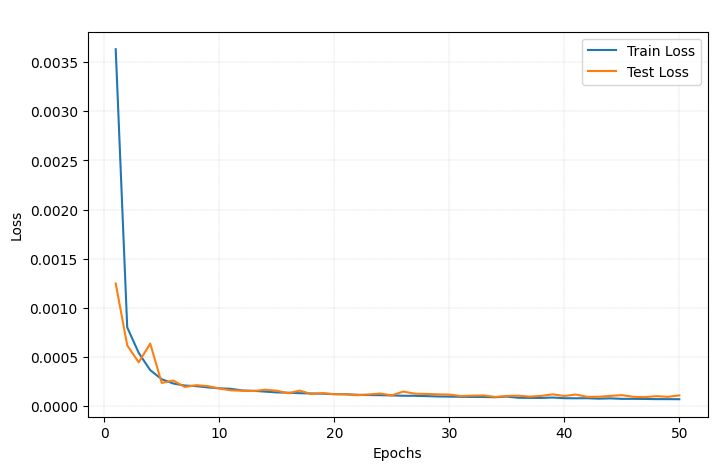

In [18]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training the model

Load Saved Model to skip Training

In [19]:
# with open(config.kmeans_ae_3D_TEadd_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [20]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_3d_TEadd_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [21]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=True, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=True, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=True, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [25]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=30)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

In [26]:
unique, counts = np.unique(eval_subpatch_predictions, return_counts=True)
print(dict(zip(unique, counts)))

{0: 876, 1: 321}


Clustering Accuracy

In [27]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 68.85
Precision: 68.18
Recall: 85.71
F1-score: 75.95
F2-score: 81.52


Assign field labels to training data for creating final visualisation images

In [ ]:
train_field_labels = assign_field_labels_ae_train(combined_train_coords, train_subpatch_predictions, disease, config.subpatch_to_patch_threshold) #for box drawing

Save Models

In [28]:
# with open(config.ae_3d_TEadd_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [29]:
# with open(config.kmeans_ae_3D_TEadd_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

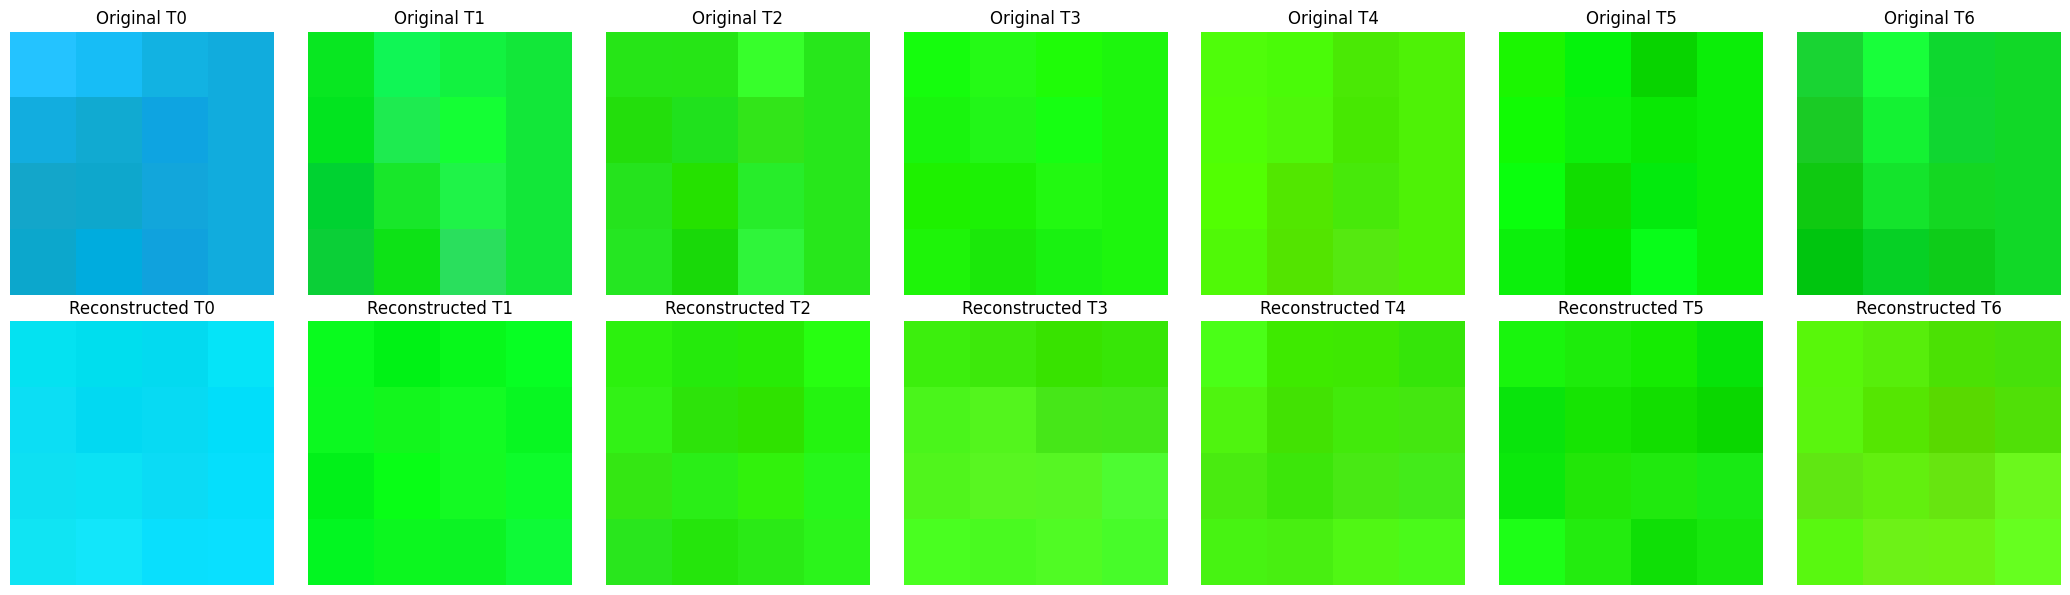

In [33]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_eval, 1, device, model_type='ae_te')

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

/tmp/ipykernel_277975/2135193741.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, 7, 2)


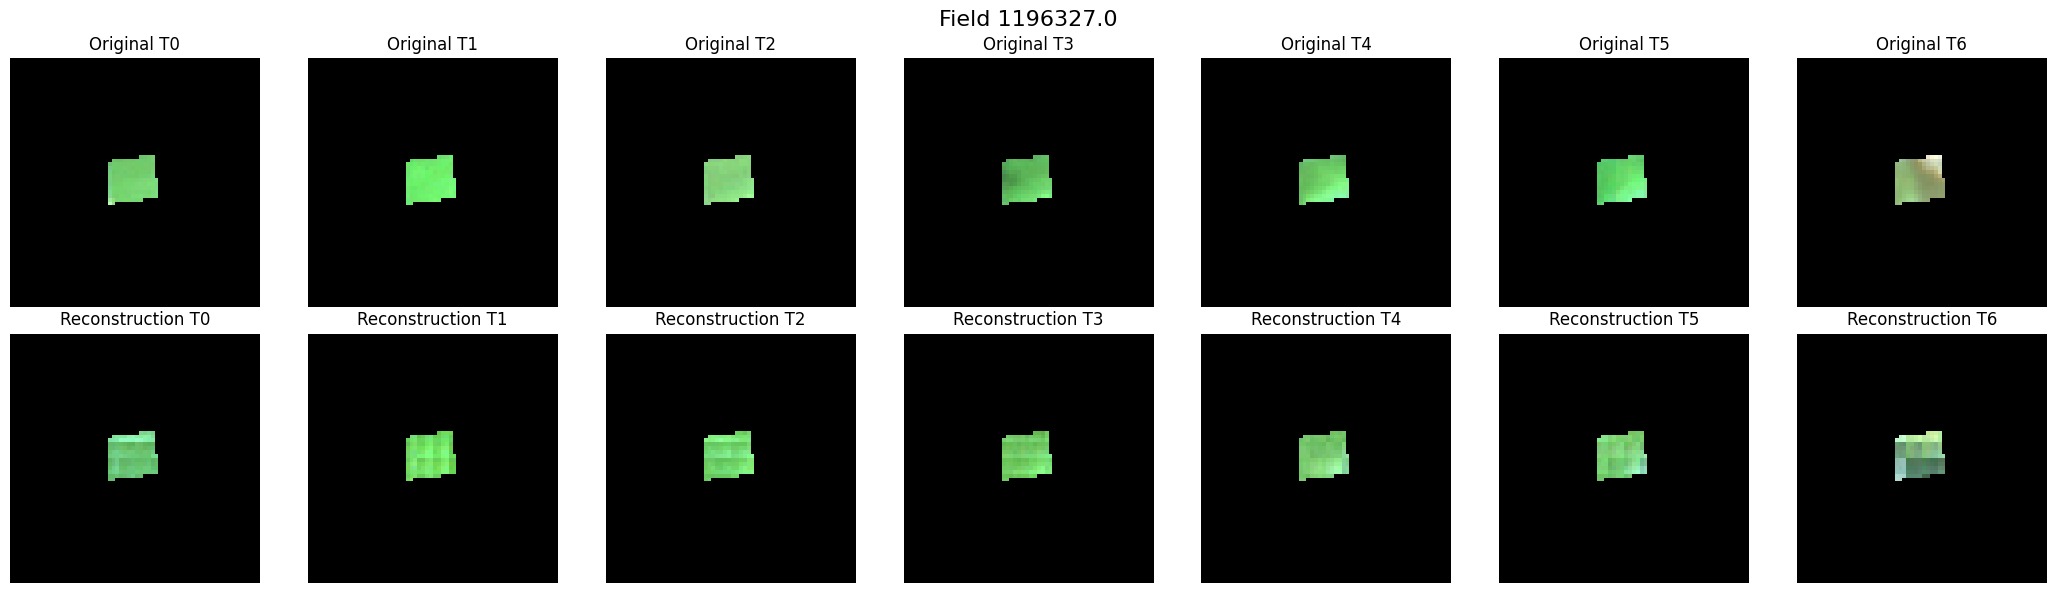

In [47]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device, model_type='ae_te')

## Final Images: Visualising Diseased Subpatches

Here the best model - Conv3d Autoencoder with pixel-level addiion of date encodings is used

In [374]:
eval_images_box = images_visualisation_eval

In [375]:
(eval_images_box[0][0].shape)

(64, 64, 12)

In [376]:
np.unique(eval_images_box[0][0][:,:,-2])

array([0.70156171])

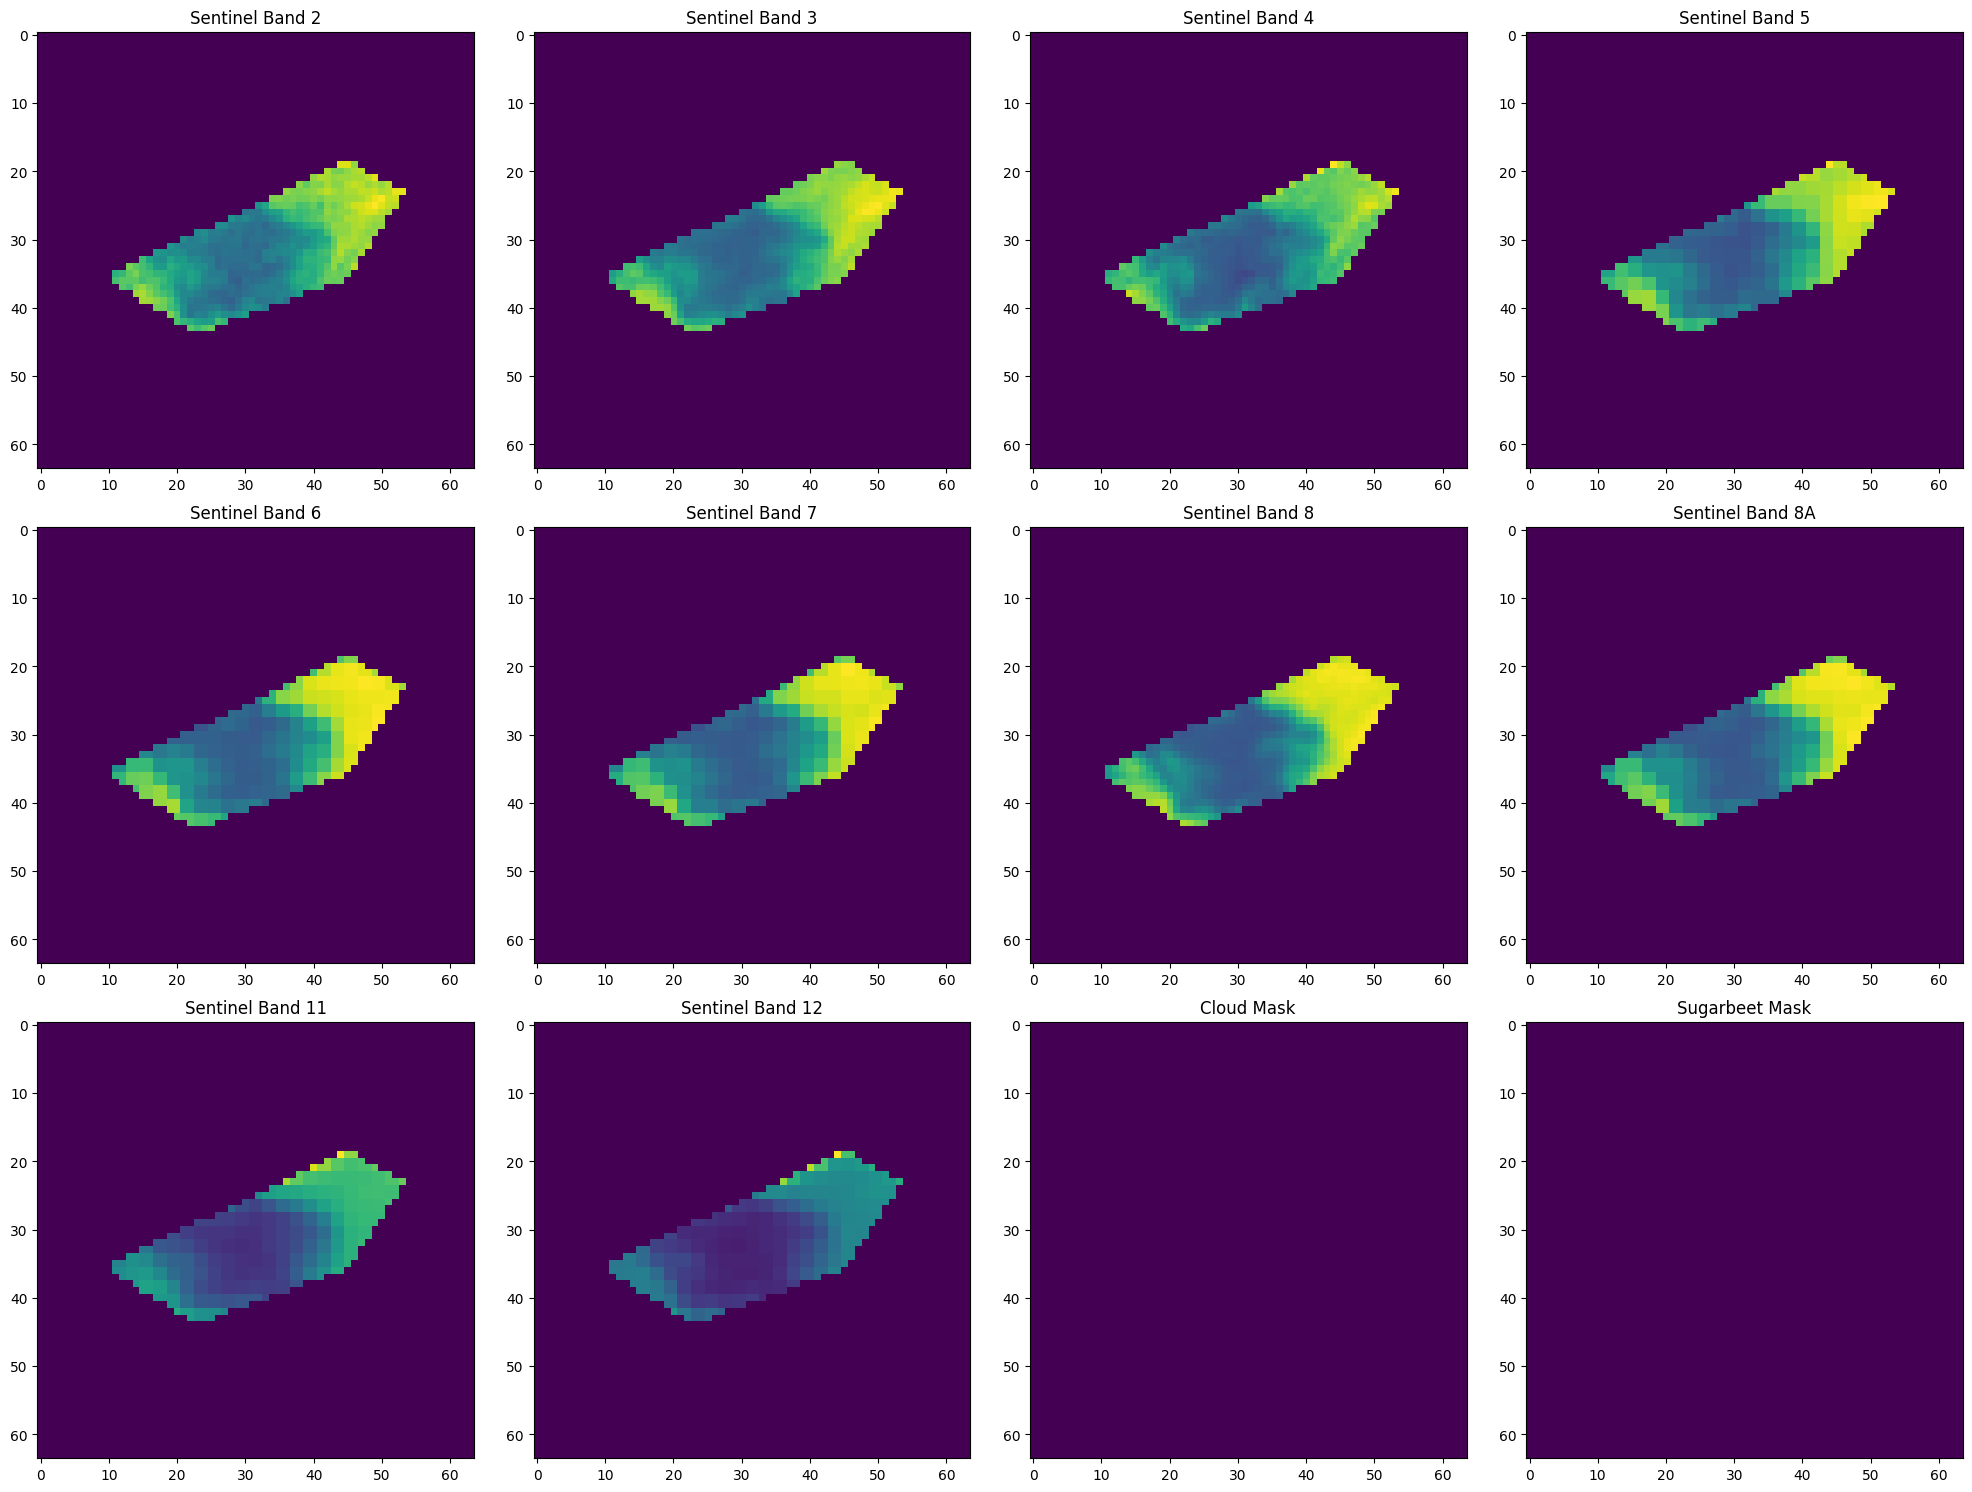

In [377]:
visualise_all_bands(eval_images_box[-15][3])

-48 -26

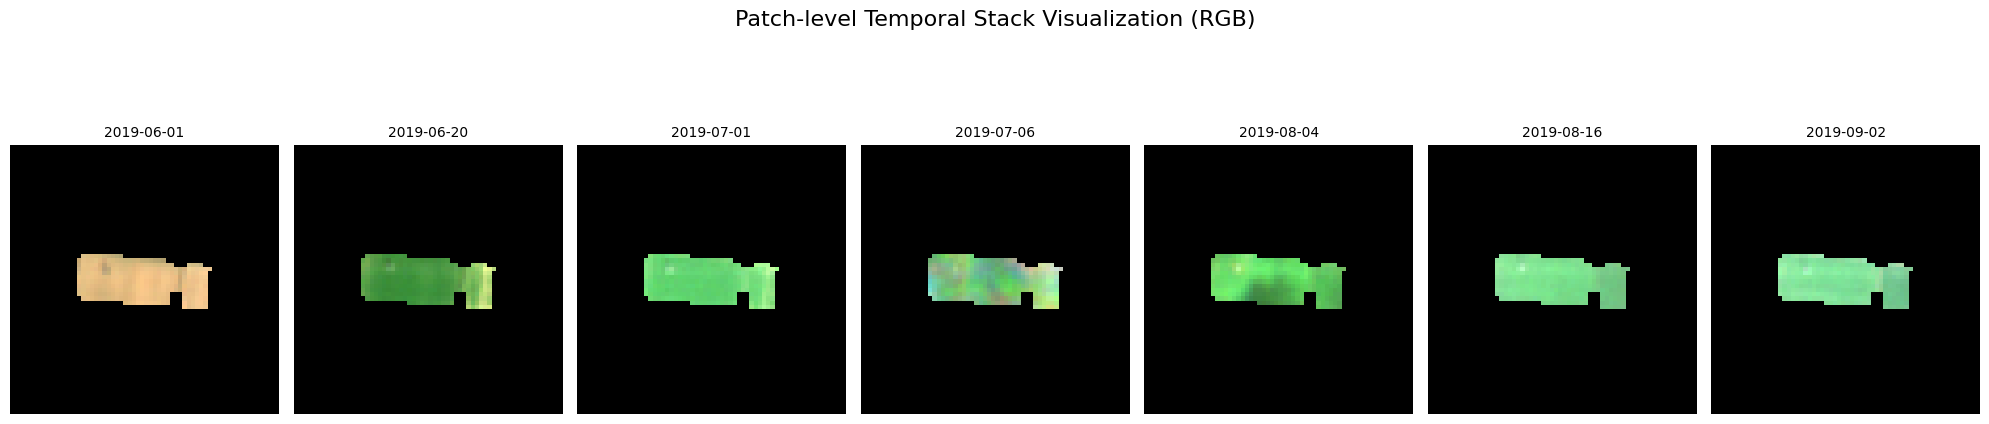

In [380]:
visualize_temporal_stack_rgb(eval_images_box[-26],acquisition_dates_eval[-26])

In [381]:
np.unique(eval_images_box[-26][-1][:,:,-2])

array([0.9633448])

In [ ]:
draw_diseased_patches(eval_images_box, x_y_coords, config.images_save_path, config.patch_size)

## Filtering non-sb fields

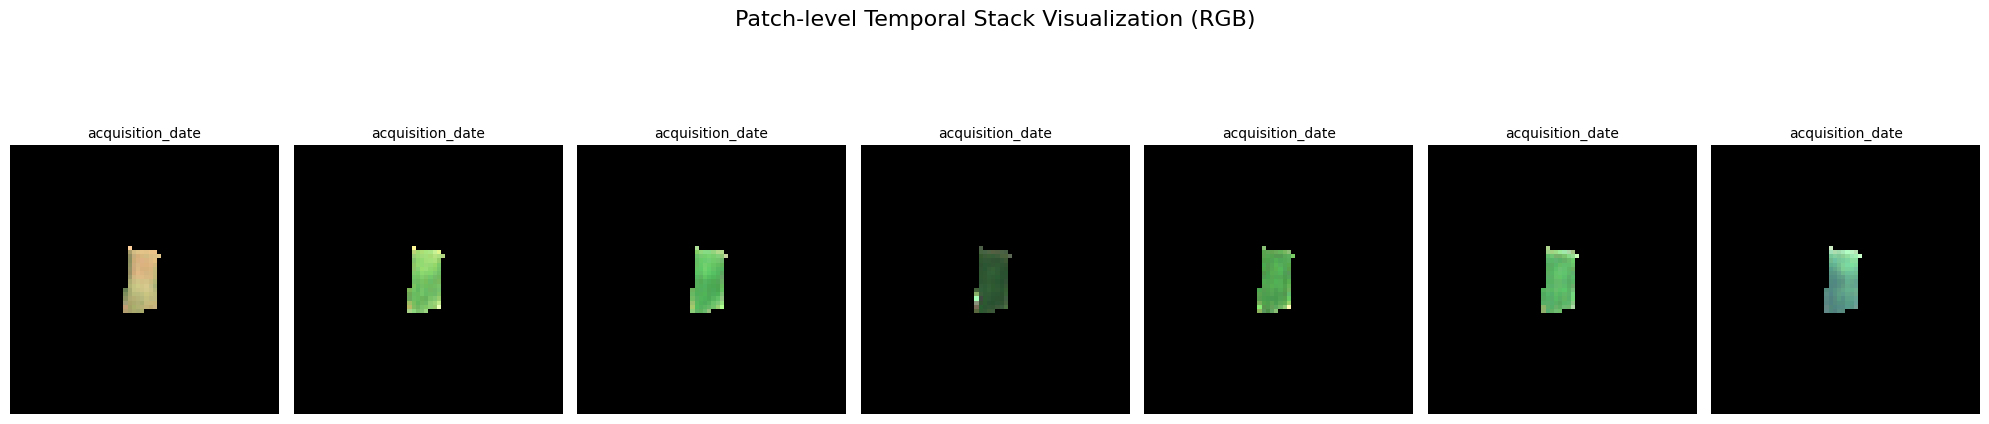

In [130]:
temporal_images = load_field_images_temporal(config.load_directory_temporal_train)
visualize_temporal_stack_rgb(temporal_images[0],[])

In [131]:
np.unique(temporal_images[0][0][:,:,-2])

array([      0., 1167134.])

In [139]:
temporal_images[0][0].shape

(64, 64, 13)

In [132]:
len(temporal_images)

2425

In [137]:
filtered_images = filter_non_sugarbeet_fields(temporal_images, config.sugarbeet_content_csv_path)
len(filtered_images)

1228

In [140]:
filtered_images[0][0].shape

(64, 64, 13)